<a href="https://colab.research.google.com/github/MoncefDj/AI-DS-Masters/blob/main/TP_DL_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP 01 Deep learning

 ## Installing Required Package

In [ ]:
# Install PyDrive for accessing and downloading files from Google Drive
!pip install -U -q PyDrive

## Importing Required Libraries

In [ ]:
# Import necessary libraries for deep learning operations, image processing, and visualization
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os  # Import OS module to interact with the file system
from sklearn.utils import shuffle  # Import shuffle function for data shuffling
import numpy as np
from PIL import Image  # Used for image loading and preprocessing
import matplotlib.pyplot as plt  # Used for plotting graphs and visualizations
import os  # Used for navigating the file system
import time  # Used for measuring training time
import seaborn as sns  # Used for enhanced visual plots
from sklearn.metrics import precision_recall_fscore_support  # Used for calculating performance metrics

## Downloading and Extracting the Data File

In [ ]:
# Authenticate the user and create a PyDrive client
auth.authenticate_user()  # Authenticate user with Google account
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  # Create a GoogleDrive client
# Specify the file ID of the desired file from Google Drive
file_id = '1ZtVTTxAHMavnYdeCUoqQyaZkNk_eF3IR'  # Replace with your actual file ID

# Download the file from Google Drive and save it with the original title
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(downloaded['title'])  # Saves the file to Colab with its original name
file_name = downloaded['title']
print(f"Downloaded file: {file_name}")

# Check the directory to confirm the file has been downloaded
!ls

# Extract the .rar file to the current directory
!unrar x {file_name}  # Extracts the .rar file contents

# Remove the .rar file after extraction to save space
os.remove(file_name)
print(f"Deleted .rar file: {file_name}")

# List the directory contents to verify extraction
!ls


Downloaded file: Dataset.rar
Dataset.rar  sample_data

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from Dataset.rar

Creating    apple                                                     OK
Creating    apple/test                                                OK
Extracting  apple/test/1.png                                               0%  OK 
Extracting  apple/test/10.png                                              0%  OK 
Extracting  apple/test/11.png                                              1%  OK 
Extracting  apple/test/12.png                                              1%  OK 
Extracting  apple/test/13.png                                              1%  OK 
Extracting  apple/test/14.png                                              2%  OK 
Extracting  apple/test/15.png                                              2%  OK 
Extracting  apple/test/16.png                      

## Image Preprocessing Function

In [ ]:
# Function to convert images to grayscale, resize them, and normalize
def preprocess_image(image_path):
    try:
        img = Image.open(image_path).convert('L')  # Convert image to grayscale
        # img = img.resize((32, 32))  # Resize image to 32x32 for consistency
        # return np.array(img).flatten()
        return np.array(img).flatten() / 255.0  # Normalize pixel values to range [0, 1]
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None  # Return None if an error occurs


## Loading the Dataset

In [ ]:
# Function to load training and test datasets from specified paths
def load_dataset(base_path):
    X_train, y_train = [], []
    X_test, y_test = [], []

    # Load apple training images (class 0)
    apple_train_path = os.path.join(base_path, 'apple', 'train')
    for img_name in os.listdir(apple_train_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(apple_train_path, img_name)
            img_data = preprocess_image(img_path)
            if img_data is not None:
                X_train.append(img_data)
                y_train.append(0)  # Class label for apples

    # Load apple test images (class 0)
    apple_test_path = os.path.join(base_path, 'apple', 'test')
    for img_name in os.listdir(apple_test_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(apple_test_path, img_name)
            img_data = preprocess_image(img_path)
            if img_data is not None:
                X_test.append(img_data)
                y_test.append(0)  # Class label for apples

    # Load lemon training images (class 1)
    lemon_train_path = os.path.join(base_path, 'lemon', 'train')
    for img_name in os.listdir(lemon_train_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(lemon_train_path, img_name)
            img_data = preprocess_image(img_path)
            if img_data is not None:
                X_train.append(img_data)
                y_train.append(1)  # Class label for lemons

    # Load lemon test images (class 1)
    lemon_test_path = os.path.join(base_path, 'lemon', 'test')
    for img_name in os.listdir(lemon_test_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(lemon_test_path, img_name)
            img_data = preprocess_image(img_path)
            if img_data is not None:
                X_test.append(img_data)
                y_test.append(1)  # Class label for lemons

    # Convert lists to numpy arrays for further processing
    X_train = np.array(X_train)
    y_train = np.array(y_train).reshape(-1, 1)
    X_test = np.array(X_test)
    y_test = np.array(y_test).reshape(-1, 1)

    # Shuffle the sets
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    X_test, y_test = shuffle(X_test, y_test, random_state=42)

    print(f"Loaded {len(X_train)} training images and {len(X_test)} test images")
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")

    return X_train, y_train, X_test, y_test

## Defining the MLP Class

In [ ]:
class MLP:
    def __init__(self, input_size, hidden_size, output_size, activation='sigmoid'):
        # Initialize network architecture parameters
        # Small random weights and zero biases for both layers
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01  # Input to hidden layer weights
        self.b1 = np.zeros((1, hidden_size))                       # Hidden layer bias
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01 # Hidden to output layer weights
        self.b2 = np.zeros((1, output_size))                       # Output layer bias
        self.activation = activation                               # Store activation function choice

    def activation_function(self, x):
        # Implement different activation functions
        if self.activation == 'sigmoid':
            # Sigmoid: squashes values between 0 and 1
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'relu':
            # ReLU: returns max between 0 and input
            return np.maximum(0, x)
        elif self.activation == 'tanh':
            # Tanh: squashes values between -1 and 1
            return np.tanh(x)

    def activation_derivative(self, x):
        # Implement derivatives of activation functions for backpropagation
        if self.activation == 'sigmoid':
            # Derivative of sigmoid: f'(x) = f(x)(1 - f(x))
            fx = self.activation_function(x)
            return fx * (1 - fx)
        elif self.activation == 'relu':
            # Derivative of ReLU: 1 if x > 0, 0 otherwise
            return (x > 0).astype(float)
        elif self.activation == 'tanh':
            # Derivative of tanh: 1 - tanh^2(x)
            return 1 - np.tanh(x)**2

    def forward(self, X):
        # Forward propagation through the network

        # Hidden layer computation
        self.Z1 = np.dot(X, self.W1) + self.b1     # Linear transformation
        self.A1 = self.activation_function(self.Z1) # Apply activation function

        # Output layer computation
        self.Z2 = np.dot(self.A1, self.W2) + self.b2 # Linear transformation
        self.A2 = self.activation_function(self.Z2)   # Apply same activation function

        return self.A2

    def backward(self, X, y, learning_rate):
        # Get number of training examples in current batch
        m = X.shape[0]

        # Calculate gradient for output layer using MSE loss derivative
        dZ2 = 2 * (self.A2 - y) * self.activation_derivative(self.Z2)

        # Calculate gradient for output layer weights (W2)
        dW2 = (1/m) * np.dot(self.A1.T, dZ2)

        # Calculate gradient for output layer bias (b2)
        db2 = (1/m) * np.sum(dZ2, axis=0, keepdims=True)

        # Propagate error backwards to hidden layer
        dA1 = np.dot(dZ2, self.W2.T)

        # Calculate gradient for hidden layer
        dZ1 = dA1 * self.activation_derivative(self.Z1)

        # Calculate gradient for hidden layer weights (W1)
        dW1 = (1/m) * np.dot(X.T, dZ1)

        # Calculate gradient for hidden layer bias (b1)
        db1 = (1/m) * np.sum(dZ1, axis=0, keepdims=True)

        # Update weights and biases using gradient descent
        self.W2 -= learning_rate * dW2  # Update output layer weights
        self.b2 -= learning_rate * db2  # Update output layer bias
        self.W1 -= learning_rate * dW1  # Update hidden layer weights
        self.b1 -= learning_rate * db1  # Update hidden layer bias

## Training Function

In [ ]:
def train(model, X_train, y_train, X_test, y_test, epochs, batch_size, learning_rate, mode='sgd'):
    # Initialize empty lists to store training and test losses
    train_losses = []
    test_losses = []
    m = X_train.shape[0]  # Number of training examples

    for epoch in range(epochs):
        # Batch Gradient Descent: Update weights using entire dataset at once
        if mode == 'bgd':
            model.forward(X_train)
            model.backward(X_train, y_train, learning_rate)

        # Stochastic Gradient Descent: Update weights using one example at a time
        elif mode == 'sgd':
            for i in range(m):
                xi = X_train[i:i+1]  # Single training example
                yi = y_train[i:i+1]  # Single training label
                model.forward(xi)
                model.backward(xi, yi, learning_rate)

        # Mini-batch Gradient Descent: Update weights using small batches
        else:
            for i in range(0, m, batch_size):
                xi = X_train[i:i+batch_size]  # Batch of training examples
                yi = y_train[i:i+batch_size]  # Batch of training labels
                model.forward(xi)
                model.backward(xi, yi, learning_rate)

        # Calculate and store training loss (MSE) for current epoch
        y_pred_train = model.forward(X_train)
        train_loss = np.mean((y_train - y_pred_train) ** 2)
        train_losses.append(train_loss)

        # Calculate and store test loss (MSE) for current epoch
        y_pred_test = model.forward(X_test)
        test_loss = np.mean((y_test - y_pred_test) ** 2)
        test_losses.append(test_loss)

        # Print progress every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Training MSE: {train_loss:.4f}, Test MSE: {test_loss:.4f}")

    return train_losses, test_losses

## Plotting Functions

In [ ]:
# Function to plot the confusion matrix and metrics
def plot_confusion_matrix(y_true, y_pred, title):
    # Convert predictions to binary (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate confusion matrix
    cm = np.zeros((2, 2))
    for i in range(len(y_true)):
        cm[int(y_true[i]), int(y_pred_binary[i])] += 1

    # Extract performance metrics from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Create figure with two subplots for visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot confusion matrix heatmap
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax1)
    ax1.set_title(f'{title}\nConfusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    ax1.set_xticklabels(['Apple', 'Lemon'])
    ax1.set_yticklabels(['Apple', 'Lemon'])

    # Plot performance metrics
    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    ax2.bar(metrics.keys(), metrics.values(), color='skyblue')
    ax2.set_title('Performance Metrics')
    ax2.set_ylim([0, 1])
    for i, v in enumerate(metrics.values()):
        ax2.text(i, v + 0.01, f'{v:.3f}', ha='center')

    plt.tight_layout()
    plt.show()

    return metrics  # Return metrics for further analysis



## Plotting Loss Curve

In [ ]:
def plot_loss(train_losses, test_losses, title):
    # Create a new figure with specified size
    plt.figure(figsize=(10, 5))

    # Plot training loss curve in blue
    plt.plot(train_losses, 'b-', label='Training Loss')

    # Plot test loss curve in red
    plt.plot(test_losses, 'r-', label='Test Loss')

    # Add title and labels
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Add legend to distinguish between training and test curves
    plt.legend()

    # Display the plot
    plt.show()

## Running Experiments

In [ ]:
def run_experiments(X_train, y_train, X_test, y_test, configurations):
    results = {}
    all_metrics = {}

    # Iterate through each configuration combination
    for config in configurations:
        activation, mode, zero_init = config

        # Print current configuration details
        print(f"\n{'='*50}")
        print(f"Testing Configuration:")
        print(f"Activation: {activation.upper()}")
        print(f"Training Mode: {mode.upper()}")
        print(f"Zero Initialization: {zero_init}")

        # Initialize model with current configuration
        model = MLP(input_size, hidden_size, output_size, activation)

        # If zero initialization is selected, set weights to zero
        if zero_init:
            model.W1 = np.zeros_like(model.W1)
            model.W2 = np.zeros_like(model.W2)

        # Train the model and measure training time
        start_time = time.time()
        train_losses, test_losses = train(model, X_train, y_train, X_test, y_test,
                                        epochs, batch_size, learning_rate, mode)
        training_time = time.time() - start_time

        # Get predictions on test set
        y_pred = model.forward(X_test)

        # Create configuration name for plotting and storing results
        config_name = f"{activation}_{mode}"
        if zero_init:
            config_name += "_zero_init"

        # Generate and display plots
        print("\nGenerating plots...")
        plot_loss(train_losses, test_losses, f'Loss Curves - {config_name}')
        metrics = plot_confusion_matrix(y_test, y_pred, f'Results - {config_name}')

        # Store all metrics for this configuration
        all_metrics[config_name] = {
            'training_time': training_time,
            'final_train_loss': train_losses[-1],
            'final_test_loss': test_losses[-1],
            **metrics
        }

    return all_metrics

## Main Execution Block

Loaded 200 training images and 100 test images
Training set shape: (200, 10000)
Test set shape: (100, 10000)
Dataset Statistics:
Training samples: 200
Testing samples: 100
Input dimension: 10000

Testing Configuration:
Activation: RELU
Training Mode: SGD
Zero Initialization: False
Epoch 0, Training MSE: 0.1531, Test MSE: 0.1986
Epoch 10, Training MSE: 0.0874, Test MSE: 0.2045
Epoch 20, Training MSE: 0.0611, Test MSE: 0.1923
Epoch 30, Training MSE: 0.0427, Test MSE: 0.1764
Epoch 40, Training MSE: 0.0310, Test MSE: 0.1667
Epoch 50, Training MSE: 0.0236, Test MSE: 0.1631
Epoch 60, Training MSE: 0.0174, Test MSE: 0.1592
Epoch 70, Training MSE: 0.0137, Test MSE: 0.1571
Epoch 80, Training MSE: 0.0094, Test MSE: 0.1601
Epoch 90, Training MSE: 0.0089, Test MSE: 0.1483

Generating plots...


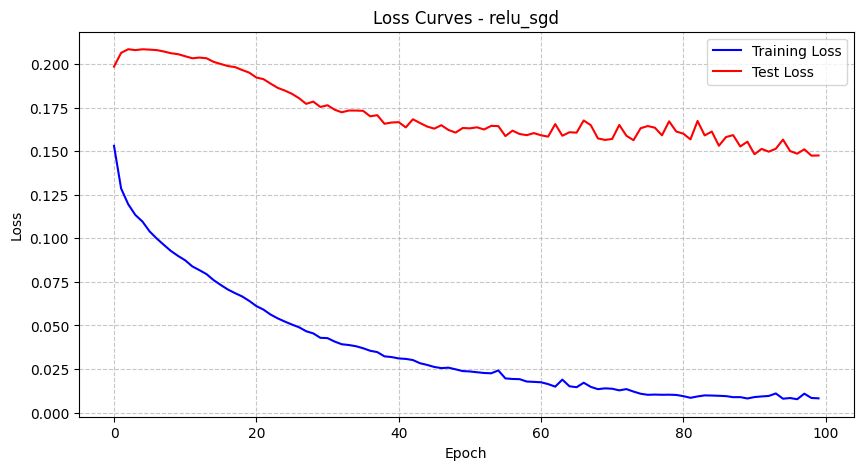

<ipython-input-8-85ad9ed67108>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cm[int(y_true[i]), int(y_pred_binary[i])] += 1


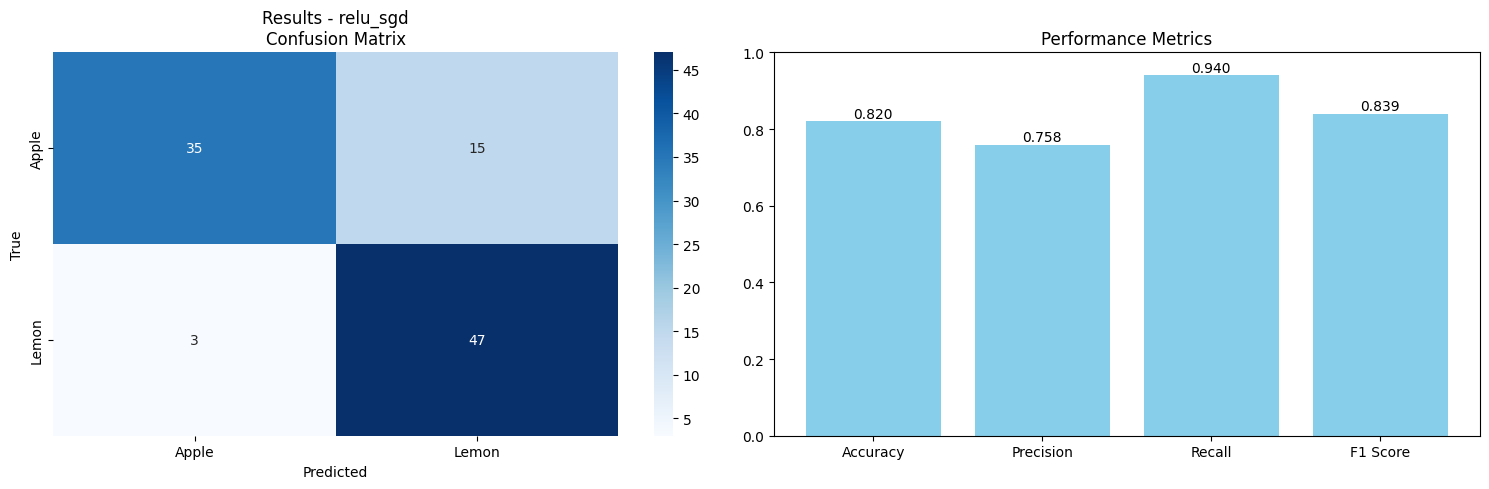


Testing Configuration:
Activation: RELU
Training Mode: BGD
Zero Initialization: False
Epoch 0, Training MSE: 0.4159, Test MSE: 0.4116
Epoch 10, Training MSE: 0.2396, Test MSE: 0.2196
Epoch 20, Training MSE: 0.2020, Test MSE: 0.1908
Epoch 30, Training MSE: 0.1955, Test MSE: 0.1908
Epoch 40, Training MSE: 0.1914, Test MSE: 0.1905
Epoch 50, Training MSE: 0.1876, Test MSE: 0.1897
Epoch 60, Training MSE: 0.1838, Test MSE: 0.1888
Epoch 70, Training MSE: 0.1800, Test MSE: 0.1878
Epoch 80, Training MSE: 0.1763, Test MSE: 0.1868
Epoch 90, Training MSE: 0.1726, Test MSE: 0.1859

Generating plots...


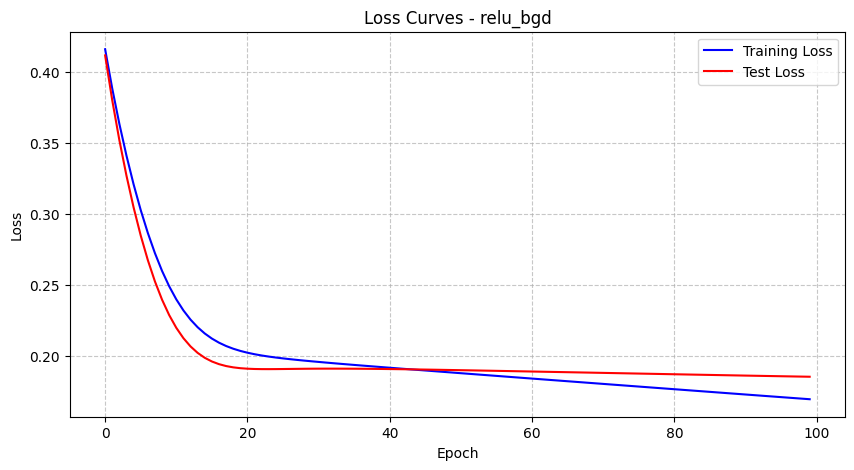

<ipython-input-8-85ad9ed67108>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cm[int(y_true[i]), int(y_pred_binary[i])] += 1


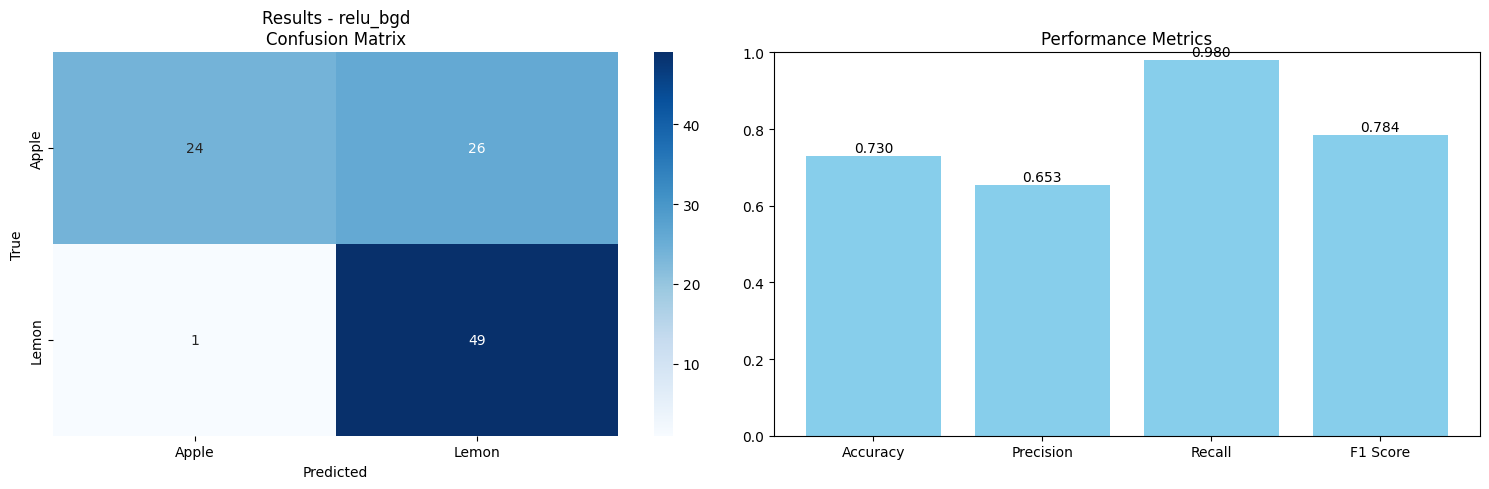


Testing Configuration:
Activation: RELU
Training Mode: MGD
Zero Initialization: False
Epoch 0, Training MSE: 0.4986, Test MSE: 0.4993
Epoch 10, Training MSE: 0.1991, Test MSE: 0.1935
Epoch 20, Training MSE: 0.1724, Test MSE: 0.1862
Epoch 30, Training MSE: 0.1486, Test MSE: 0.1812
Epoch 40, Training MSE: 0.1324, Test MSE: 0.1803
Epoch 50, Training MSE: 0.1235, Test MSE: 0.1820
Epoch 60, Training MSE: 0.1184, Test MSE: 0.1840
Epoch 70, Training MSE: 0.1146, Test MSE: 0.1848
Epoch 80, Training MSE: 0.1110, Test MSE: 0.1844
Epoch 90, Training MSE: 0.1082, Test MSE: 0.1849

Generating plots...


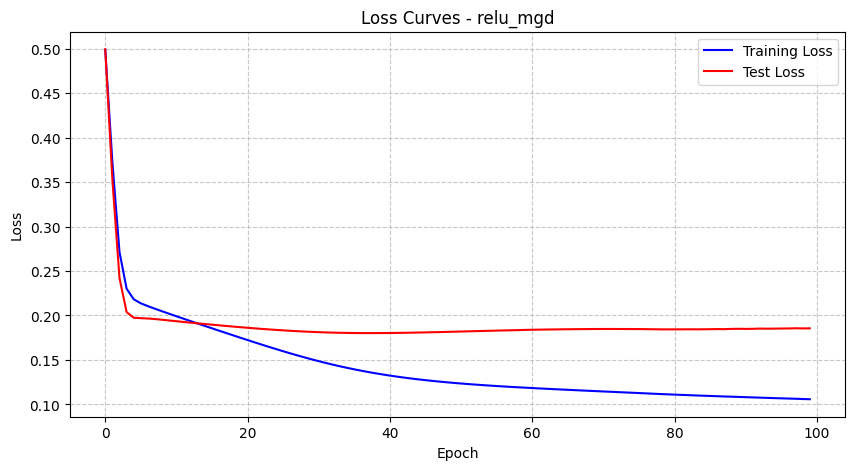

<ipython-input-8-85ad9ed67108>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cm[int(y_true[i]), int(y_pred_binary[i])] += 1


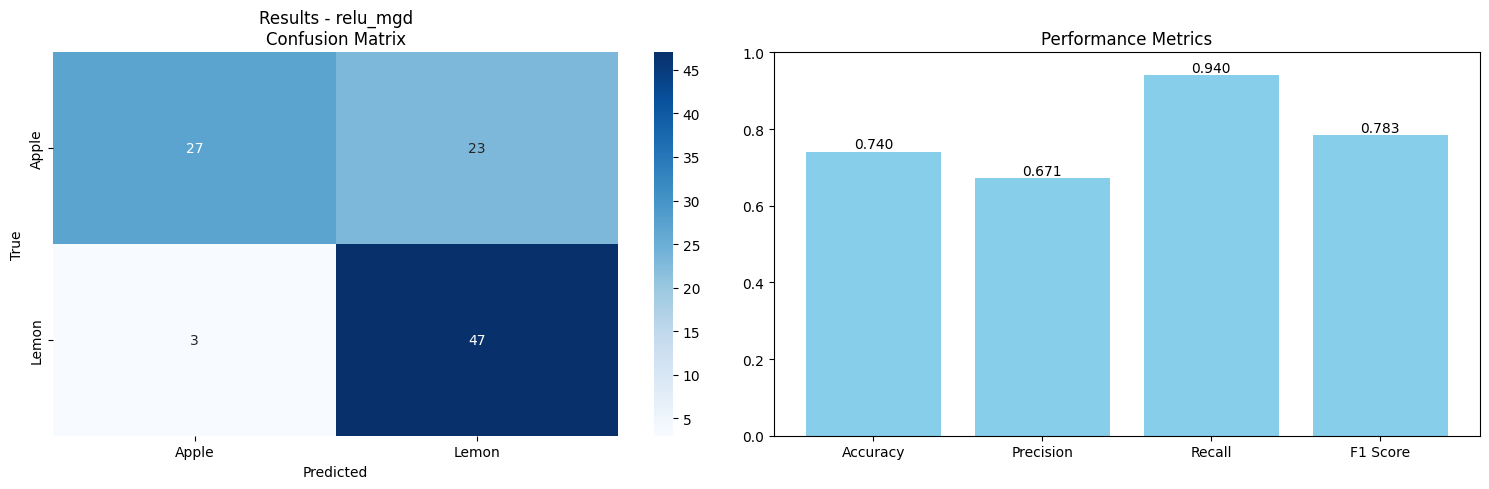


Testing Configuration:
Activation: SIGMOID
Training Mode: SGD
Zero Initialization: False
Epoch 0, Training MSE: 0.2497, Test MSE: 0.2495
Epoch 10, Training MSE: 0.2431, Test MSE: 0.2447
Epoch 20, Training MSE: 0.2277, Test MSE: 0.2361
Epoch 30, Training MSE: 0.1984, Test MSE: 0.2232
Epoch 40, Training MSE: 0.1678, Test MSE: 0.2110
Epoch 50, Training MSE: 0.1474, Test MSE: 0.2034
Epoch 60, Training MSE: 0.1346, Test MSE: 0.1990
Epoch 70, Training MSE: 0.1256, Test MSE: 0.1961
Epoch 80, Training MSE: 0.1186, Test MSE: 0.1940
Epoch 90, Training MSE: 0.1126, Test MSE: 0.1922

Generating plots...


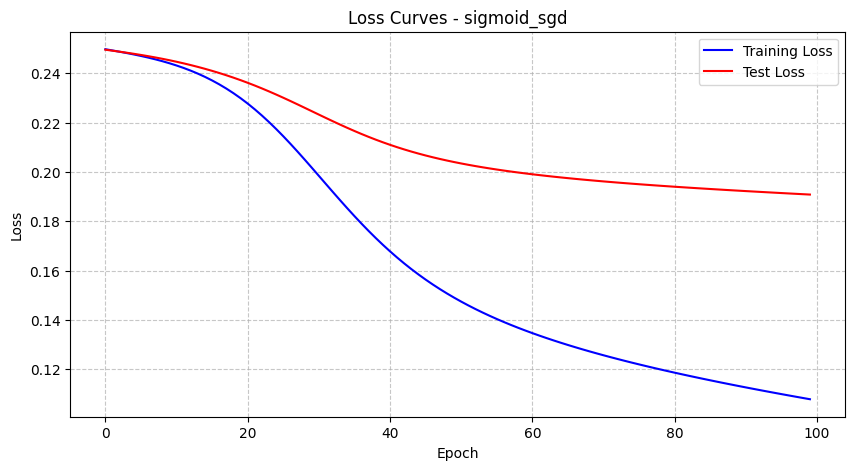

<ipython-input-8-85ad9ed67108>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cm[int(y_true[i]), int(y_pred_binary[i])] += 1


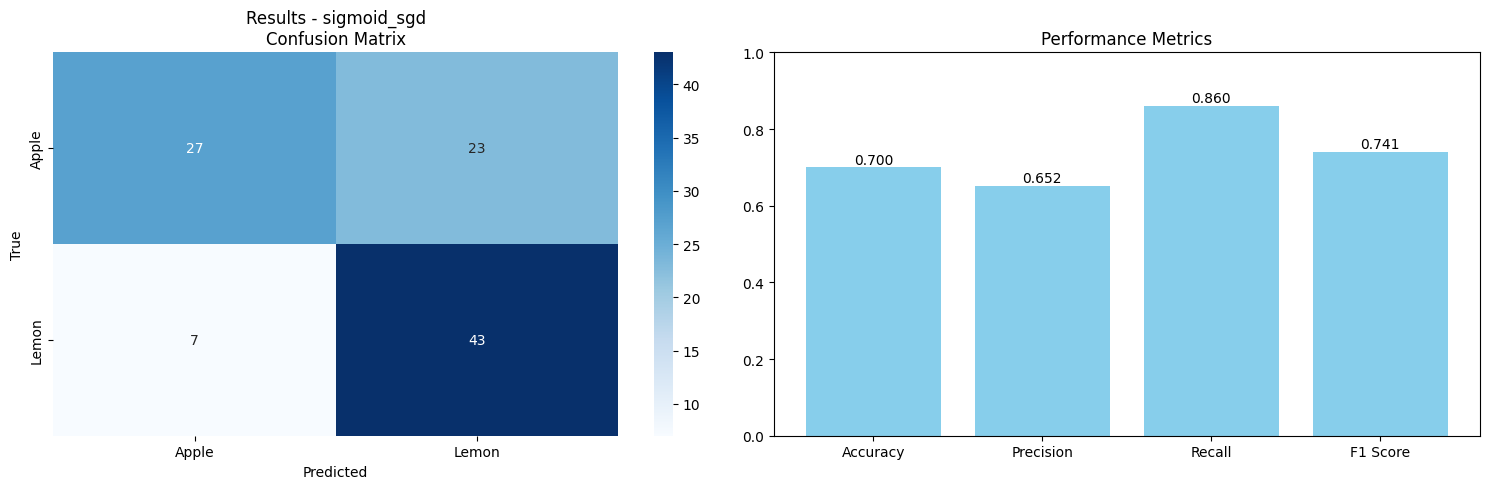


Testing Configuration:
Activation: SIGMOID
Training Mode: BGD
Zero Initialization: False
Epoch 0, Training MSE: 0.2498, Test MSE: 0.2500
Epoch 10, Training MSE: 0.2498, Test MSE: 0.2500
Epoch 20, Training MSE: 0.2498, Test MSE: 0.2500
Epoch 30, Training MSE: 0.2497, Test MSE: 0.2500
Epoch 40, Training MSE: 0.2497, Test MSE: 0.2499
Epoch 50, Training MSE: 0.2497, Test MSE: 0.2499
Epoch 60, Training MSE: 0.2497, Test MSE: 0.2499
Epoch 70, Training MSE: 0.2496, Test MSE: 0.2499
Epoch 80, Training MSE: 0.2496, Test MSE: 0.2499
Epoch 90, Training MSE: 0.2496, Test MSE: 0.2498

Generating plots...


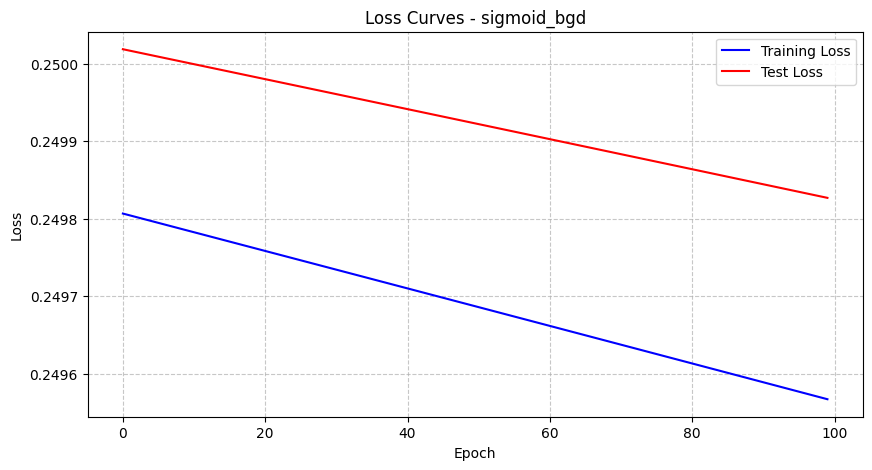

<ipython-input-8-85ad9ed67108>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cm[int(y_true[i]), int(y_pred_binary[i])] += 1


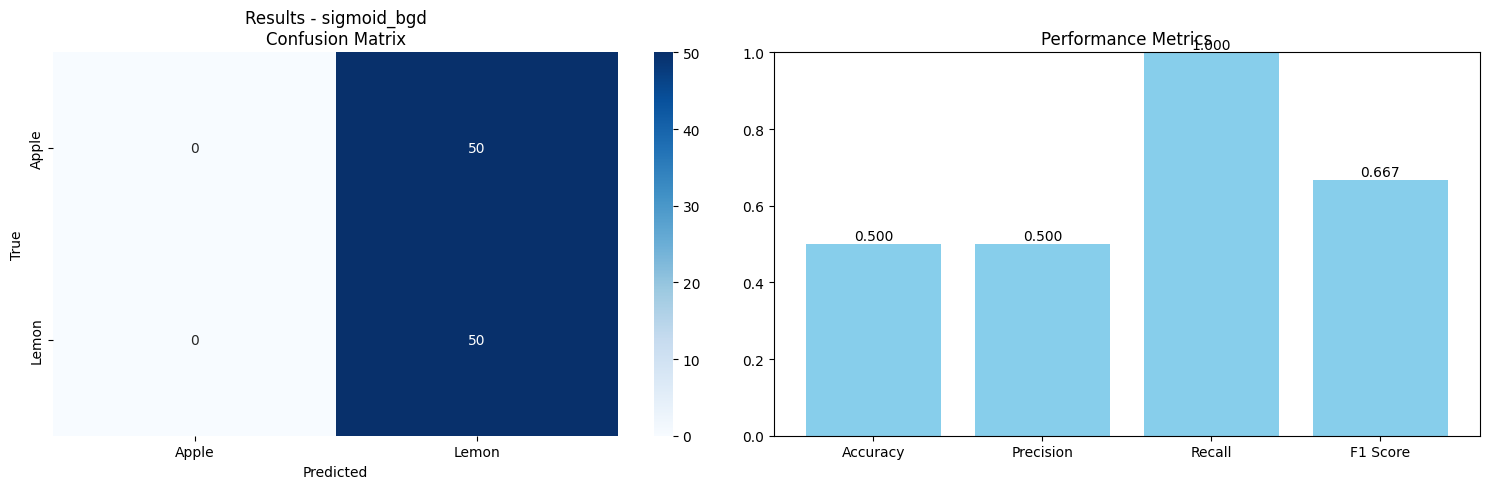


Testing Configuration:
Activation: SIGMOID
Training Mode: MGD
Zero Initialization: False
Epoch 0, Training MSE: 0.2503, Test MSE: 0.2503
Epoch 10, Training MSE: 0.2501, Test MSE: 0.2502
Epoch 20, Training MSE: 0.2500, Test MSE: 0.2500
Epoch 30, Training MSE: 0.2498, Test MSE: 0.2499
Epoch 40, Training MSE: 0.2497, Test MSE: 0.2498
Epoch 50, Training MSE: 0.2495, Test MSE: 0.2496
Epoch 60, Training MSE: 0.2493, Test MSE: 0.2495
Epoch 70, Training MSE: 0.2492, Test MSE: 0.2494
Epoch 80, Training MSE: 0.2490, Test MSE: 0.2492
Epoch 90, Training MSE: 0.2489, Test MSE: 0.2491

Generating plots...


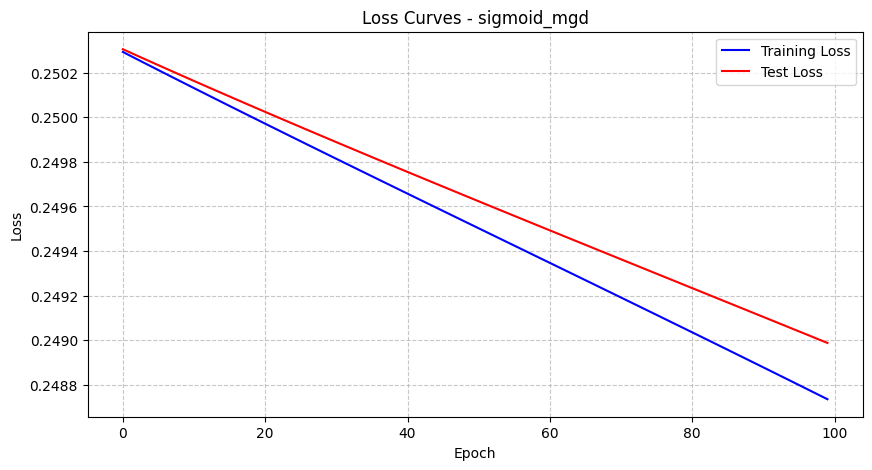

<ipython-input-8-85ad9ed67108>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cm[int(y_true[i]), int(y_pred_binary[i])] += 1


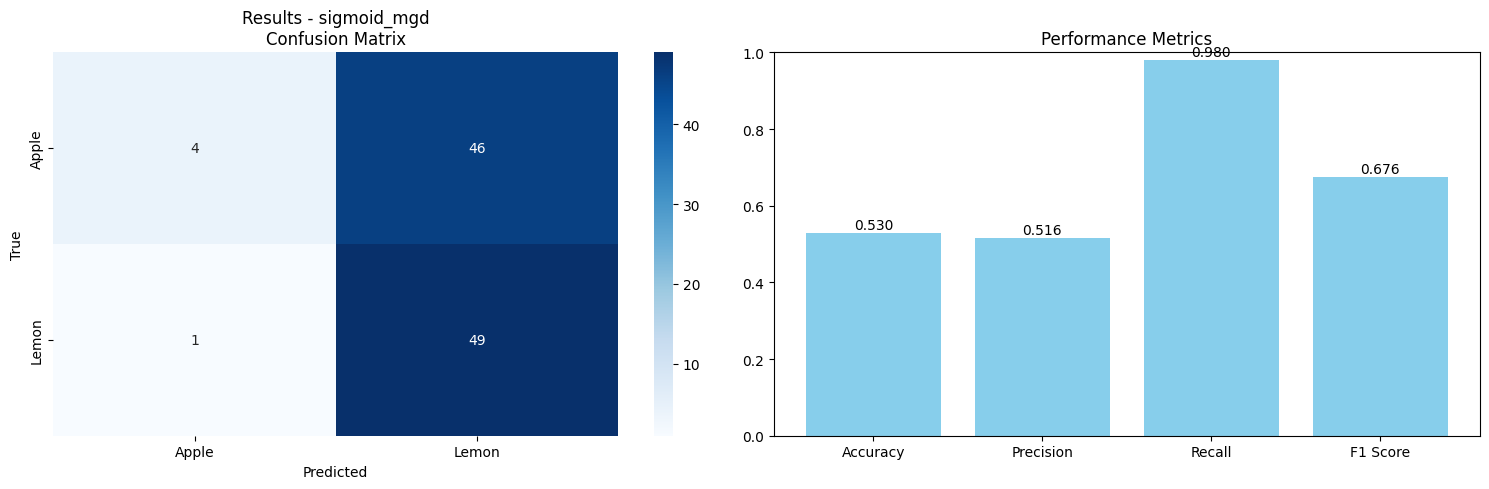


Testing Configuration:
Activation: RELU
Training Mode: SGD
Zero Initialization: True
Epoch 0, Training MSE: 0.5000, Test MSE: 0.5000
Epoch 10, Training MSE: 0.5000, Test MSE: 0.5000
Epoch 20, Training MSE: 0.5000, Test MSE: 0.5000
Epoch 30, Training MSE: 0.5000, Test MSE: 0.5000
Epoch 40, Training MSE: 0.5000, Test MSE: 0.5000
Epoch 50, Training MSE: 0.5000, Test MSE: 0.5000
Epoch 60, Training MSE: 0.5000, Test MSE: 0.5000
Epoch 70, Training MSE: 0.5000, Test MSE: 0.5000
Epoch 80, Training MSE: 0.5000, Test MSE: 0.5000
Epoch 90, Training MSE: 0.5000, Test MSE: 0.5000

Generating plots...


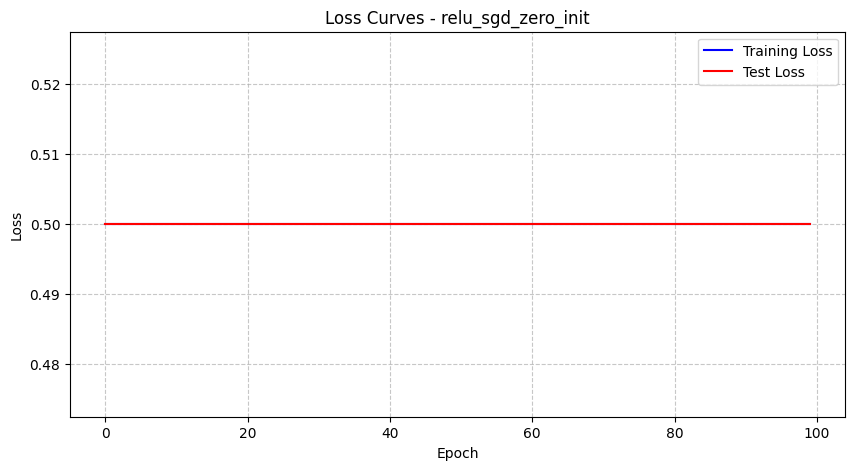

<ipython-input-8-85ad9ed67108>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cm[int(y_true[i]), int(y_pred_binary[i])] += 1


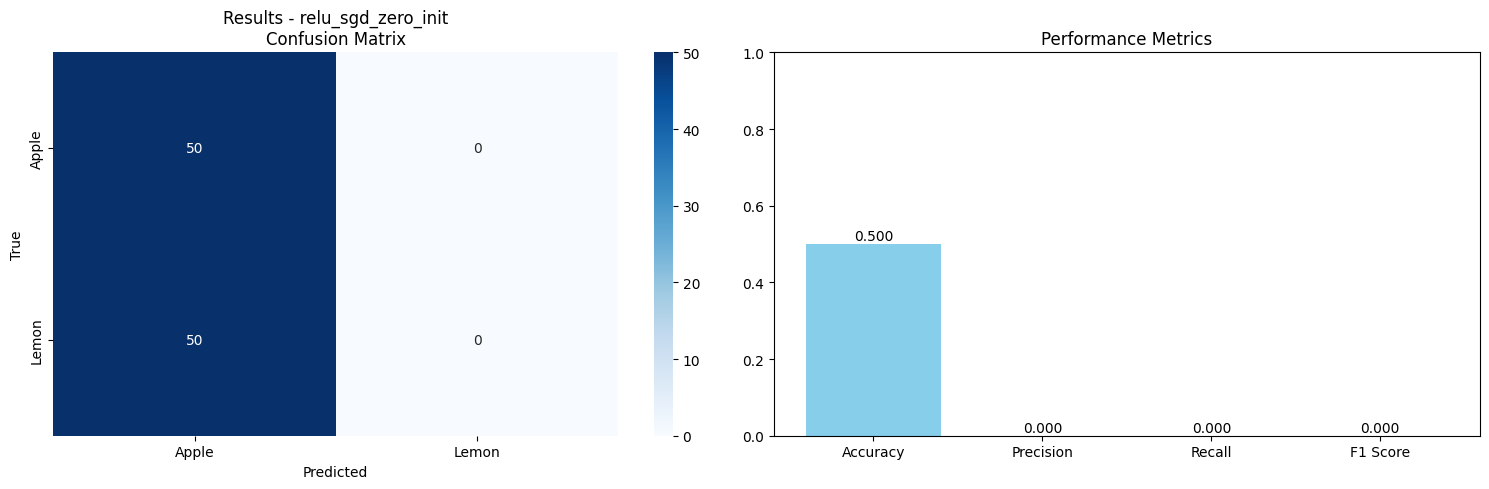


Comparative Results:
------------------------------------------------------------------------------------------------------------------------
Configuration        Train Time(s)   Final Train Loss Final Test Loss Accuracy   Precision  Recall     F1 Score  
------------------------------------------------------------------------------------------------------------------------
relu_sgd             83.26           0.0081          0.1476          0.8200     0.7581     0.9400     0.8393    
relu_bgd             4.89            0.1693          0.1851          0.7300     0.6533     0.9800     0.7840    
relu_mgd             9.42            0.1059          0.1856          0.7400     0.6714     0.9400     0.7833    
sigmoid_sgd          86.57           0.1078          0.1908          0.7000     0.6515     0.8600     0.7414    
sigmoid_bgd          6.87            0.2496          0.2498          0.5000     0.5000     1.0000     0.6667    
sigmoid_mgd          7.48            0.2487          0.24

In [ ]:
# Main function to execute the entire pipeline
if __name__ == "__main__":
    # Configuration parameters for the MLP
    # input_size = 32 * 32  # Flattened input size (32x32 grayscale images)
    input_size = 100 * 100  # Flattened input size (32x32 grayscale images)
    hidden_size = 64  # Number of neurons in the hidden layer
    output_size = 1  # Output layer size for binary classification
    learning_rate = 0.001  # Learning rate for gradient descent
    epochs = 100  # Total number of training epochs
    batch_size = 32  # Batch size for mini-batch gradient descent

    # Load the dataset (update the path to your dataset)
    dataset_path = ""  # Replace with your actual dataset path
    X_train, y_train, X_test, y_test = load_dataset(dataset_path)

    # Print dataset statistics
    print("Dataset Statistics:")
    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")
    print(f"Input dimension: {X_train.shape[1]}")

    # Define configurations for different experiments
    configurations = [
        ('relu', 'sgd', False),
        ('relu', 'bgd', False),
        ('relu', 'mgd', False),
        ('sigmoid', 'sgd', False),
        ('sigmoid', 'bgd', False),
        ('sigmoid', 'mgd', False),
        ('relu', 'sgd', True)  # Zero initialization test
    ]

    # Run the experiments
    results = run_experiments(X_train, y_train, X_test, y_test, configurations)

    # Display the final comparative results in a tabular format
    print("\nComparative Results:")
    print("-" * 120)
    headers = ['Configuration', 'Train Time(s)', 'Final Train Loss', 'Final Test Loss', 'Accuracy', 'Precision', 'Recall', 'F1 Score']
    print("{:<20} {:<15} {:<15} {:<15} {:<10} {:<10} {:<10} {:<10}".format(*headers))
    print("-" * 120)

    for config, metrics in results.items():
        row = [
            config,
            f"{metrics['training_time']:.2f}",
            f"{metrics['final_train_loss']:.4f}",
            f"{metrics['final_test_loss']:.4f}",
            f"{metrics['Accuracy']:.4f}",
            f"{metrics['Precision']:.4f}",
            f"{metrics['Recall']:.4f}",
            f"{metrics['F1 Score']:.4f}"
        ]
        print("{:<20} {:<15} {:<15} {:<15} {:<10} {:<10} {:<10} {:<10}".format(*row))